공부 내용
- Supervised Fine Tuning
- Reward Model의 ranking algorithm 및 loss fuction 설계 원리
- 언어모델을 강화학습하기 위한 방법론

cloud shell에서 아래와 같이 KochatGPT를 설치
    cd aiffel 
    git clone https://github.com/airobotlab/KoChatGPT  
    cd KoChatGPT/colossalai_ChatGPT_230319/
    pip install .  

In [ ]:
import torch

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
!pip list | grep transformers # transformers 4.28.0

#  Base model and Dataset for RLHF

 backbone 모델로 사용할 KoGPT-2의 성능 확인하기  
 허깅페이스의 transformers를 사용하여 토크나이저와 모델을 불러오기 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

모델의 토크나이저가 입력받아 처리할 수 있는 최대 토큰 수를 확인하기

In [ ]:
tokenizer.max_model_input_sizes

kogpt-2는 어떻게 토크나이징을 하는지 확인하기

In [ ]:
input_txt = "바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."

In [ ]:
tokens = tokenizer(input_txt).tokens()
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].numpy()

In [ ]:
pd.options.display.max_columns = 40
pd.options.display.max_rows = 60
df = pd.DataFrame([tokens, input_ids[0]], index=["kogpt-2_tokens", "Input_IDs"])
df

디코딩 성능도 확인하기   
시퀀스 반복 출력은 그리디 서치 디코딩시 발견되는 전형적인 현상이다.

In [ ]:
max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

이번엔 빔 서치 디코딩을 사용하고 n-gram 패널티까지 부과해보기  
입력 시퀀스와 별 상관 없어 보이는 긴 문단이 생성이 되는 것을 확인 할 수 있음

In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2,
                             do_sample=False)
print(tokenizer.decode(output_beam[0]))

샘플링 기법까지 추가해 보기

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, temperature=2.0, top_k=50)
print(tokenizer.decode(output_beam[0]))

top_p 샘플링 기법도 사용해보기

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, top_p=0.90)
print(tokenizer.decode(output_beam[0]))

베이스라인 모델로 사용한 kogpt-2의 일반적인 성능을 확인해봤으니
구체적인 instruction과 prompting을 사용해 어떻게 디코딩을 해내는지도 확인해보면 좋겠다

## 데이터 셋 확인
SFT를 시도할 initial 모델에 쓸 데이터셋을 살펴보기

In [ ]:
import json 
data_path_1_SFT = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

RM에 사용할 데이터셋을 살펴보기

In [ ]:
data_path_2_RM = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

PPO 학습에 쓰일 데이터를 살펴보기

In [ ]:
data_path_3_PPO = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

# Supervised Fine-Tuning

## SFT
 kogpt-2를 instruction dataset으로 SFT를 진행해보기

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

모델과 토크나이저를 불러오기

In [ ]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

모델 인퍼런스 단계에서 사용할 prompt 딕셔너리 템플릿과 SFT 데이터셋 클래스를 정의하기

In [ ]:
from typing import Optional, Dict, Sequence

# Sequence-to-Sequence 모델을 학습하기 위한 데이터셋 클래스 정의
class SFT_dataset(Dataset): # Dataset 클래스를 상속받아 정의

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        
        # 데이터를 로드하는데 필요한 로그 및 패턴을 설정
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response
        
        # JSON 파일을 열고 데이터를 로드
        data_path_1_SFT = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl'
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)
        
        # 프롬프트에 대한 템플릿을 정의
        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]
        
        # 소스와 타겟 데이터를 구성
        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]
        
        # 데이터를 토큰화
        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100
        
        # 레이블을 설정
        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        
        # 데이터를 클래스 속성에 할당
        logging.warning("Loading data done!!: %d"%(len(self.labels)))

    
    # 문자열을 토큰화하여 딕셔너리 형태로 반환
    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )

    # 데이터셋의 총 길이를 반환
    def __len__(self):
        return len(self.input_ids)

    # 주어진 인덱스에 해당하는 데이터를 반환하는 메서드
    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

데이터셋의 각 인스턴스를 처리하여 모델 학습에 필요한 형식으로 데이터를 준비하는 데이터 콜레이터(DataCollator) 클래스를 정의하기  
이 클래스는 데이터셋을 배치 단위로 처리할 때 사용된다

In [ ]:
@dataclass # 데이터 클래스를 정의할 때 사용
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [ ]:
SFT_dataset 클래스를 사용해 훈련셋을 만들고 data collator 인스턴스를 만들기

In [ ]:
train_dataset = SFT_dataset(data_path_1_SFT='/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

In [ ]:
훈련을 위한 마지막 단계로 Training arguments를 사용해 trainer 클래스를 정의하기

Warmup 단계는 학습률을 조절하기 위한 기술 중 하나입니다.   
주로 Transformer 모델과 같은 대규모 모델을 학습할 때 사용됩니다.  
Warmup 단계에서는 초기에 학습률을 작게 시작하고, 일정 단계동안 서서히 증가시켜 모델의 안정적인 학습을 돕습니다.

In [ ]:
training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT/test", #  모델과 로그 파일의 출력 디렉토리 경로를 설정
    overwrite_output_dir=True, # 이전 출력 디렉토리를 덮어쓸지 여부를 결정
    num_train_epochs=1, # 학습할 epoch 수
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5, # 학습률을 조절하기 위한 warmup 단계 수를 설정
    prediction_loss_only=True, #  평가 단계에서 예측 손실만 계산할지 여부를 결정
    fp16 = True # 16비트 부동 소수점을 사용하여 학습할지 여부를 설정
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator, # 16비트 부동 소수점을 사용하여 학습할지 여부를 설정
    train_dataset=train_dataset
)

SFT 훈련을 진행해보기

In [ ]:
trainer.train()
model.save_pretrained('/aiffel/KoChatGPT/output_1_SFT')

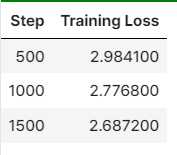

이제 문장 생성 능력을 확인하기 위해  
빠르게 허깅페이스의 pipleline 클래스를 사용하여 generator를 만들어보기

In [ ]:
# 텍스트 생성 파이프라인 생성
'''
Hugging Face의 pipeline을 사용하여 텍스트 생성 파이프라인을 생성합니다.
- text-generation은 텍스트 생성 작업을 수행하는 파이프라인을 지정합니다.
- model 인자에는 텍스트를 생성할 모델의 경로를 지정합니다.
- tokenizer 인자에는 사용할 토크나이저를 지정합니다.
'''
generator = pipeline('text-generation', model='/aiffel/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

# 텍스트 생성 매개변수 설정
'''
텍스트 생성에 사용할 매개변수를 설정합니다. 각 매개변수에 대한 설명은 아래와 같습니다:
- num_beams: 빔 검색의 너비입니다. 생성 시 빔 검색을 사용하여 생성합니다.
- repetition_penalty: 반복 페널티 값입니다. 반복되는 텍스트를 피하기 위해 사용됩니다.
- no_repeat_ngram_size: 반복을 방지할 n-gram 크기입니다.
- eos_token_id: 종료 토큰의 ID입니다. 생성된 텍스트의 종료를 나타냅니다.
- max_new_tokens: 최대 생성 토큰 수입니다.
- do_sample: 샘플링 여부를 결정합니다.
- top_k: 상위 k개의 토큰만 고려하여 샘플링합니다.
- early_stopping: 생성이 완료되면 조기 종료할지 여부를 결정합니다.
'''
generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

# 프롬프트 생성
# 생성할 텍스트의 프롬프트를 지정합니다. 각 프롬프트는 PROMPT_DICT에 따라 포맷되어야 합니다.
list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

# 텍스트 생성 및 결과 출력
'''
생성기를 사용하여 각 프롬프트에 대한 텍스트를 생성하고, 결과를 출력합니다.
generator에는 생성할 프롬프트와 매개변수가 전달됩니다.
list_result에는 각 프롬프트에 대한 생성된 텍스트가 포함됩니다.
zip을 사용하여 프롬프트와 생성된 결과를 묶고, 각각을 출력합니다.
'''
list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

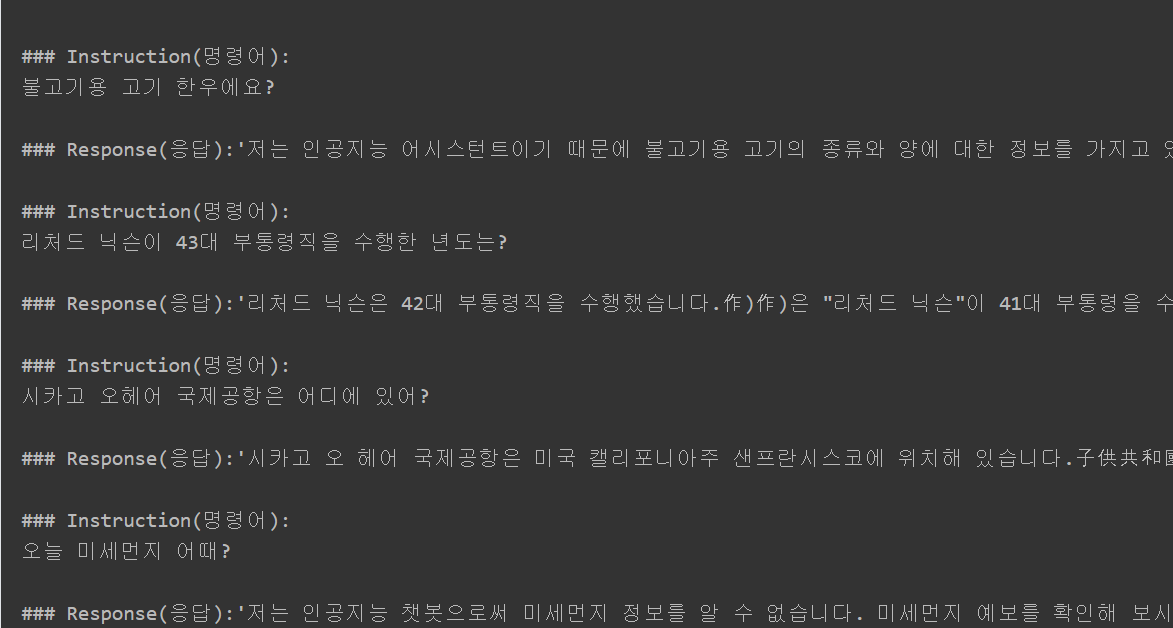

[Text generation strategies](https://huggingface.co/docs/transformers/v4.28.1/en/generation_strategies)

SFT 단계를 최적화하기 위해선 무엇보다도 instruction dataset의 품질과 initial모델의 언어모델링 성능이 중요하다.  

메모리 관리를 위해 캐시를 비우고 넘어가기

In [ ]:
torch.cuda.empty_cache()

# Reward Model

In [ ]:
# 챗봇 보상 모델의 학습을 위한 구성
import os
import json
from typing import Optional

import torch
import torch.nn as nn
from torch.optim import Adam

from chatgpt.dataset import RewardDataset # 보상 모델을 학습하기 위한 데이터셋 클래스
from chatgpt.models.base import RewardModel # 보상 모델을 정의하는 기본 클래스
from chatgpt.trainer import RewardModelTrainer # 보상 모델을 학습시키는 트레이너 클래스
from chatgpt.trainer.strategies import NaiveStrategy #  학습 전략을 정의하는 클래스 

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
# GPT-2 모델의 설정 및 모델 클래스를 불러오기 위해 사용
from transformers.models.gpt2.configuration_gpt2 import GPT2Config 
from transformers.models.gpt2.modeling_gpt2 import GPT2Model

import loralib as lora

Reward model을 설계해보자  

[원본 코드](https://github.com/hpcaitech/ColossalAI/blob/2e16f842a9e5b1fb54e7e41070e9d2bb5cd64d7c/applications/ChatGPT/chatgpt/nn/gpt_rm.py)

In [ ]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None, # 사전 훈련된 모델의 경로
                 config: Optional[GPT2Config] = None, #  GPT 모델의 설정을 지정
                 checkpoint: bool = False, # 그래디언트 체크포인팅을 사용할지 여부
                 lora_rank: int = 0, #  LoRA 알고리즘의 랭크
                 lora_train_bias: str = 'none', #  LoRA 알고리즘의 학습 바이어스를 지정
                 tokenizer=None) -> None: # 토크나이저 객체를 지정
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        # config가 지정되어 있으면, 주어진 설정으로 새로운 GPT-2 모델을 생성합니다.
        # 그렇지 않으면, 기본 GPT-2 모델을 생성합니다.
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1) # GPT 모델의 임베딩 차원 수 # 선형 레이어의 출력 차원 수
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

사용할 모델과 토크나이저를 불러오겠습니다.  
with구문의 NaiveStrategy()는 chatgpt/trainer/strategies 폴더의 base 모듈에서 정의된 Strategy클래스를 상속한 NaiveStrategy클래스입니다.

In [ ]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

RM을 훈련시킬 때 사용할 ranking dataset을 만들어보겠습니다.

In [ ]:
# JSON 파일 읽기
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

# 데이터 처리
total_data_ranking2chosen = [] # 처리된 데이터를 저장
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

kochatgpt_2_RM.jsonl 은 chatGPT, davinch, ada 세개 모델에 같은 prompt를 주고 얻은 세 답변을 순서대로 good, bad, worst로 간주해 순서를 뒤섞어 completion_0, completion_1, completion_2 세 키에 할당하여 만든 데이터셋.  

위와 같이 코드를 짜게 되면 chosen과 resjected에 각각 completion_0, completion_1, completion_2 세개 답변이 가능한 모든 조합으로 들어가게 되어
chosen에 worst 답변이 들어가고 rejected에 good답변이 들어간 데이터도 만들어집니다.

RM의 loss function은 pairwiseloss라는 이름으로 설계되어 있습니다.

class PairWiseLoss(nn.Module):

    def forward(self, chosen_reward: torch.Tensor, reject_reward: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(chosen_reward - reject_reward)
        log_probs = torch.log(probs)
        loss = -log_probs.mean()
        return loss

완성한 ranking dataset을 shuffle한 후 훈련셋을 만들어보기

In [ ]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

In [ ]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

데이터셋이 잘 만들어졌는지 하나를 뽑아 확인

In [ ]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

RM을 학습해보기

In [ ]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [ ]:
trainer.fit(use_lora=0)

model.save_pretrained('aiffel/KoChatGPT/output_2_RM')

학습이 잘 되어 있는지 확인해보기

In [ ]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

In [ ]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

In [ ]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

In [ ]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

 메모리 관리를 위해 한 번더 캐시를 비우기

In [ ]:
torch.cuda.empty_cache()

# Proximal Policy Optimization
RLHF의 마지막 세번째 단계인 PPO를 실습

In [ ]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

In [ ]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/aiffel/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

모델학습에 사용할 옵티마이저와 모델을 준비

In [ ]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [ ]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

PPO 학습에 쓸 데이터를 불러와 토크나이징

In [ ]:
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [ ]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

In [ ]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

PPO는 별도의 PPOTrainer 클래스를 설계하여 학습시켜줘야 한다

In [ ]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

PPO 학습을 진행

In [ ]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('aiffel/KoChatGPT/output_3_PPO')

RLHF가 적용된 koGPT-2의 생성능력을 확인

In [ ]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)